## Training ML models


Once you have explored the repository and selected an appropriate training dataset, you can download it and train a model. In this notebook we will show an example of how to do so using the [EuroSAT](https://www.eotdl.com/datasets/EuroSAT-RGB) dataset, in its RGB version.


In [1]:
from eotdl.datasets import stage_dataset

path = stage_dataset("EuroSAT-RGB", version=1, path="data", force=True, assets=True)
path

Staging assets: 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]


'data/EuroSAT-RGB'

In [2]:
!unzip {path}/EuroSAT-RGB.zip -d data/train

Archive:  data/EuroSAT-RGB/EuroSAT-RGB.zip
   creating: data/train/EuroSAT-RGB/
   creating: data/train/EuroSAT-RGB/Industrial/
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1743.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1273.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1117.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1121.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_1641.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_259.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_435.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_674.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_905.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_238.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_631.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Industrial_2292.jpg  
  inflating: data/train/EuroSAT-RGB/Industrial/Ind

> This might take a few minutes!


In order to streamline the training process, we will use the [PytorchEO](https://github.com/earthpulse/pytorchEO) library. This open source library is built on top of [Pytorch](https://pytorch.org/) and [Pytorch Lightning](https://lightning.ai/) to facilitate the design, implementation, training and deployment of deep learning models for Earth Observation. It offers AI-Ready EO datasets as well as ready-to-use tasks and models.

It is not our goal to provide a complete tutorial on how to train a model, but rather to show how to use the EOTDL. If you want to learn more about AI and training deep neural networks, we encourage you to explore the [PytorchEO](https://github.com/earthpulse/pytorchEO) library, and even contribute with more datasets, tasks, models and wrappers. We challenge you to train a better model!


In [3]:
from pytorch_eo.datasets import EuroSATRGB

# do not set download to True since it will download the dataset from the original source and not EOTDL !

ds = EuroSATRGB(
    batch_size=25,
    verbose=True,
    path="data",
    download=False,
    data_folder="train/EuroSAT-RGB",
)

ds.setup()

Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


In [4]:
ds.df

,image,label
0,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
1,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
2,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
3,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_2...,0
4,data/train/EuroSAT-RGB/AnnualCrop/AnnualCrop_1...,0
...,...,...
26995,data/train/EuroSAT-RGB/SeaLake/SeaLake_612.jpg,9
26996,data/train/EuroSAT-RGB/SeaLake/SeaLake_2863.jpg,9
26997,data/train/EuroSAT-RGB/SeaLake/SeaLake_606.jpg,9
26998,data/train/EuroSAT-RGB/SeaLake/SeaLake_2877.jpg,9


This dataset contains 27000 Sentinel 2 images classified in 10 categories.


In [5]:
ds.num_classes, ds.classes

(10,
 ['AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'])

Before training the model, let's visualize some images, with their label.


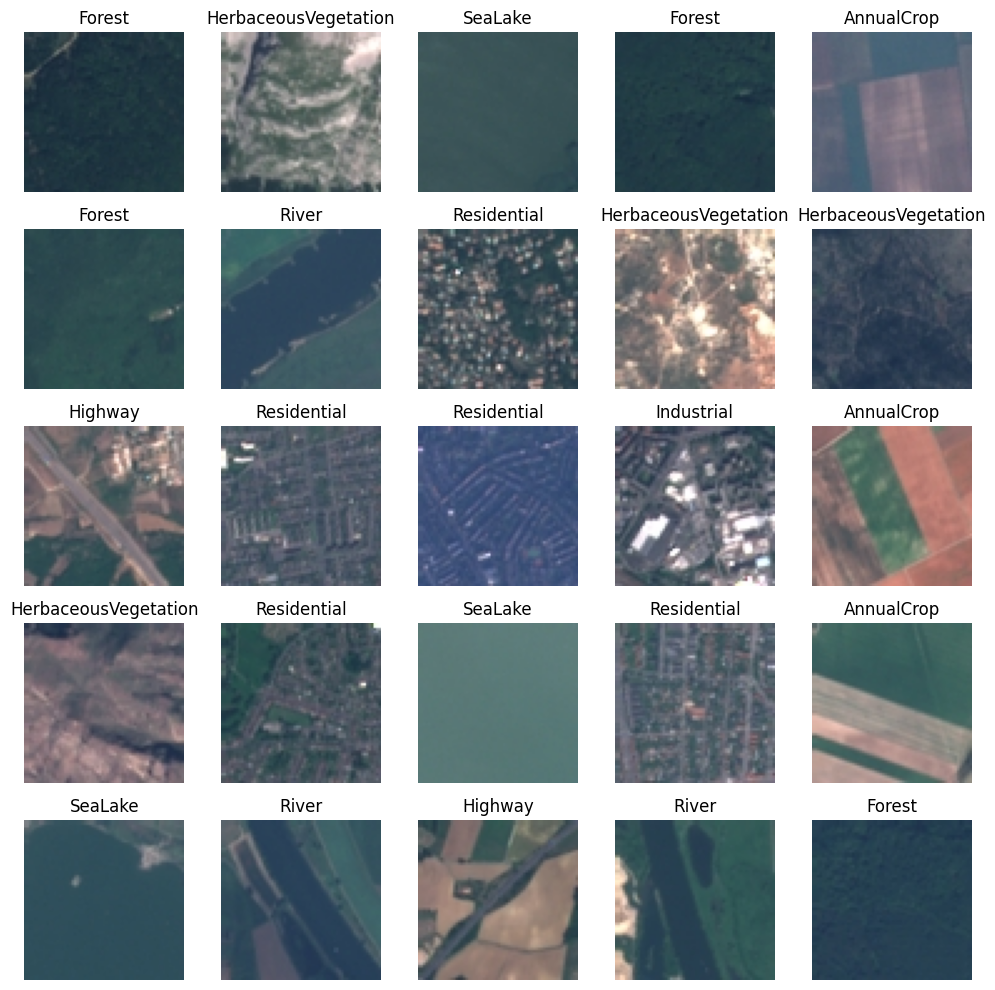

In [ ]:
import matplotlib.pyplot as plt
import torch

# take a batch from the train dataloader
batch = next(iter(ds.train_dataloader()))
imgs, labels = batch["image"], batch["label"]

# show at most 25 images (5x5)
n = min(len(imgs), 25)
rows, cols = 5, 5

fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
axes = axes.ravel()

for ax, img, label in zip(axes, imgs[:n], labels[:n]):
    # if [C,H,W] -> [H,W,C]
    img_np = img.permute(1, 2, 0).detach().cpu()
    ax.imshow(img_np)
    ax.set_title(ds.classes[int(label)])
    ax.axis("off")

# disable extra axes if n < 25
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

Now, we will create and test a simple image classification task using `pytorch_eo`.

We start by initializing an ImageClassification task, specifying the number of classes from our dataset. Then, we generate a batch of random input tensors to simulate a set of satellite image patches (8 images, 3 channels, 224x224 pixels). Finally, we pass these inputs through the model to verify that it produces an output tensor with the expected shape — one prediction per image in the batch.


In [9]:
import torch
from pytorch_eo.tasks.classification import ImageClassification

task = ImageClassification(num_classes=ds.num_classes)

sample_inputs = torch.randn(8, 3, 224, 224)
output = task(sample_inputs)
output.shape

torch.Size([8, 10])

Now that our classification task is defined, we can train it using Lightning.

Here we create a `Trainer` configured to use a GPU `(accelerator="cpu")` and run for 10 epochs. We disable checkpointing for simplicity, since this is just a quick training run.

Finally, we call `trainer.fit(task, ds)` to start the training loop: Lightning will handle batching, forward passes, backpropagation, and validation for us. This gives us a clean and reproducible way to train our model with minimal boilerplate code.


In [12]:
import lightning as L

trainer = L.Trainer(
    # accelerator="cuda",
    accelerator="cpu",
    devices=1,
    max_epochs=1,  # Change to 10 for full training
    enable_checkpointing=False,
    limit_train_batches=0.2,
    limit_val_batches=0.2,
    # limit_train_batches=50,
    # limit_val_batches=50,
)

trainer.fit(task, ds)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/fran/Documents/dev/workshop-eotdl-bids2025/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | model   | ResNet             | 11.2 M | train
1 | loss_fn | CrossEntropyLoss   | 0      | train
2 | acc     | MulticlassAccuracy | 0      | train
-------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


Number of images: 27000
Training samples 16200
Validation samples 5400
Test samples 5400


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/fran/Documents/dev/workshop-eotdl-bids2025/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/fran/Documents/dev/workshop-eotdl-bids2025/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Once training is complete, we evaluate the model on the test set.

We switch the task to evaluation mode with `task.eval()` and disable gradient computation using `torch.no_grad()` to speed up inference. Then, we loop through the test dataloader with `tqdm` to get a progress bar, compute predictions, and count how many are correct by comparing the predicted class (`argmax`) to the true label.

Finally, we print the total accuracy, giving us a quick measure of how well the trained model performs on unseen data.


In [13]:
from tqdm import tqdm

task.eval()
acc = 0
with torch.no_grad():
    for batch in tqdm(ds.test_dataloader()):
        output = task(batch["image"])
        acc += (output.argmax(1) == batch["label"]).sum().item()

print("test accuracy: ", f"{acc}/{len(ds.test_dataloader().dataset)}")

100%|██████████| 216/216 [00:29<00:00,  7.44it/s]

test accuracy:  3111/5400


To better understand our model’s performance, let's visualize predictions on a random batch from the test set.

We first extract 25 random samples from the test dataloader, then run the model to compute predictions and take the class with the highest probability. Finally, we display the images in a 5×5 grid using Matplotlib.

Each subplot shows the ground-truth label as the title, colored green if the prediction is correct and red if it is wrong — making it easy to spot where the model struggles.

This kind of visualization is a powerful way to qualitatively assess model performance beyond numerical accuracy.


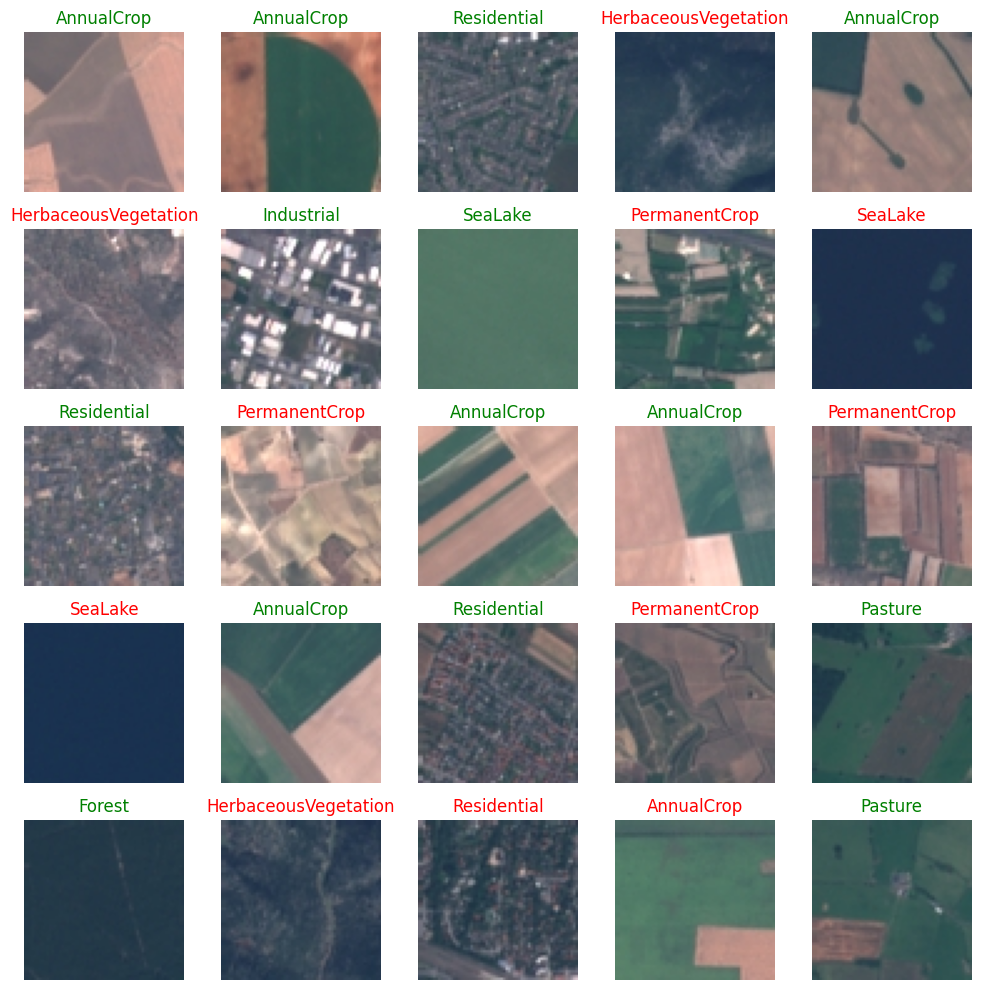

In [14]:
# extract batch from test dataloader

batch = next(iter(ds.test_dataloader(shuffle=True, batch_size=25)))
imgs, labels = batch["image"], batch["label"]

# compute predictions

preds = task.predict(batch)
preds = torch.argmax(preds, axis=1)

# visualize predictions

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs, labels, preds)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1, 2, 0))
    gt = ds.classes[label.item()]
    pred = ds.classes[pred.item()]
    ax.set_title(gt, color="green" if gt == pred else "red")
    ax.axis("off")
plt.tight_layout()
plt.show()

Finally, export it to later ingestion to the EOTDL. You can choose your preferred export method, here we use ONNX.


In [ ]:
# !pip install onnx onnxruntime

In [15]:
import os

filepath = "data/EuroSAT-RGB-model/model.onnx"
os.makedirs(os.path.dirname(filepath), exist_ok=True)

task.to_onnx(
    filepath,
    imgs,
    export_params=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size", 2: "height", 3: "width"},
        "output": {0: "batch_size"},
    },
)

Here we load a model exported to [ONNX](https://onnx.ai/) format and run inference with ONNX Runtime.

We start by creating a random input tensor (`x`) that matches the model’s expected shape, then initialize an `InferenceSession` from the ONNX file. Using the input name from the model, we pass the data to the session and execute `run`, which performs a forward pass.

Finally, we check the shape of the output tensor to confirm that the model is working correctly and producing predictions in the expected format.


In [17]:
import onnxruntime
import numpy as np

x = np.random.randn(3, 3, 132, 412).astype(np.float32)

ort_session = onnxruntime.InferenceSession(filepath)
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: x}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(3, 10)

Now we evaluate the ONNX model on the test set.

For each batch in the test dataloader, we convert the images to NumPy arrays, run inference with onnxruntime, and compare the predicted class (argmax) with the true labels. We accumulate the number of correct predictions and finally print the overall accuracy, giving us a quick measure of how well the exported model performs on unseen data.


In [18]:
acc = 0
for batch in tqdm(ds.test_dataloader()):
    ort_inputs = {input_name: batch["image"].numpy()}
    ort_outs = ort_session.run(None, ort_inputs)
    acc += np.sum((ort_outs[0].argmax(1) == batch["label"].numpy()))

print("test accuracy: ", f"{acc}/{len(ds.test_dataloader().dataset)}")

100%|██████████| 216/216 [00:16<00:00, 12.73it/s]

test accuracy:  3111/5400


The model correctly classified 3111 out of 5400 samples, achieving an accuracy of about 57.6%. This gives us a quick estimate of how well the model generalizes to unseen data.


We'll see how to ingest it in the next notebook!


## Discussion and Contribution opportunities


Feel free to ask questions now (live or through Discord) and make suggestions for future improvements.

- What would you like to see in the EOTDL concerning training?
- What are the main challenges you face when training ML models with EO data?
- What are the main datasets you would like to see in the EOTDL?
- What are the main tasks you would like to see implemented?
- What are the main models you would like to see implemented?
- What are the frameworks you would like to have wrappers for?
